In [44]:
# General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


# Modelling Imports
import sklearn
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import gensim

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

import torch
import torch.nn as nn

# Useful relative paths
data_directory = './data/NELA'

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1 – Modelling with LSTM! The modelling was done on Collab with a GPU. 

### 1.1 - Read pre-processed data

In [4]:
X = pd.read_csv('{}/complete_processed.csv'.format(data_directory))
y = X['label']
X.drop('label',axis=1)
;

''

### 1.2 - Create the Word2Vec representation an check the size of the vocabulary

In [5]:
full_processed_split=X['full_preprocessed'].apply(lambda x: x.split())
w2v_model = gensim.models.Word2Vec(sentences=full_processed_split, size=100, window=5, min_count=1)

In [6]:
len(w2v_model.wv.vocab)

153239

A little sanity check

In [7]:
w2v_model.wv.most_similar("trump")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('obama', 0.666392982006073),
 ('president', 0.6656293272972107),
 ('potus', 0.6603013277053833),
 ('realdonaldtrump', 0.5762010812759399),
 ('democrat', 0.5724592208862305),
 ('biden', 0.5466313362121582),
 ('republican', 0.5352396368980408),
 ('donald', 0.5282995700836182),
 ('clinton', 0.517661988735199),
 ('giuliani', 0.5163280963897705)]

Great! makes sense

### 1.3 - We will use Keras tokenizer to tokenize our sequences of words. 

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_processed_split)
X_lstm = tokenizer.texts_to_sequences(full_processed_split)

### 1.4 - Remove outliers with a very high number of tokens. Might not be pertinent text. Based on the histogram, we put the threshold at 700 tokens

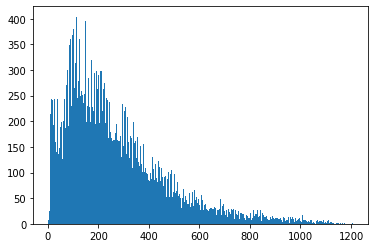

In [10]:
plt.hist([len(x) for x in X_lstm], bins=500)
plt.show() 

In [17]:
print('Percent of entries with 500 tokens or less: {}%'.format(round(len([x for x in X_lstm if len(x) <=500])*100/len(X_lstm))))
print('Percent of entries with 700 tokens or less: {}%'.format(round(len([x for x in X_lstm if len(x) <=700])*100/len(X_lstm))))

Percent of entries with 500 tokens or less: 87%
Percent of entries with 700 tokens or less: 95%


In [18]:
maxlen = 700 
X_lstm = pad_sequences(X_lstm, maxlen=maxlen)

### 1.5 - Create weight matrix based on the word-vectors embedded in the Word2Vec object

In [19]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 100))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [20]:
word_index = tokenizer.word_index
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


### 1.6 - Typical train-test-split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y,random_state=0) 

### 1.7 Create our biLSTM model

In [78]:
del(model) #clear memory

In [79]:
vocab_size = len(word_index) + 1
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_vectors], input_length=maxlen,mask_zero=True, trainable=False))
#LSTM 
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## 2. Training! :happy:

In [80]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
722/722 [==============================] - 2142s 3s/step - loss: 0.4332 - acc: 0.7912 - val_loss: 0.3793 - val_acc: 0.8194
Epoch 2/6
722/722 [==============================] - 2146s 3s/step - loss: 0.3328 - acc: 0.8488 - val_loss: 0.3465 - val_acc: 0.8363
Epoch 3/6
722/722 [==============================] - 2126s 3s/step - loss: 0.2790 - acc: 0.8766 - val_loss: 0.3289 - val_acc: 0.8493
Epoch 4/6
722/722 [==============================] - 1972s 3s/step - loss: 0.2301 - acc: 0.9014 - val_loss: 0.3332 - val_acc: 0.8471
Epoch 5/6
722/722 [==============================] - 1963s 3s/step - loss: 0.1813 - acc: 0.9251 - val_loss: 0.3531 - val_acc: 0.8511
Epoch 6/6
722/722 [==============================] - 1956s 3s/step - loss: 0.1387 - acc: 0.9444 - val_loss: 0.4153 - val_acc: 0.8502


### 2.1 - Verifiying our result metrics

In [81]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      5511
           1       0.83      0.87      0.85      5484

    accuracy                           0.85     10995
   macro avg       0.85      0.85      0.85     10995
weighted avg       0.85      0.85      0.85     10995



## 3. Saving the model (if good enough)

In [83]:
model.save('./models/LSTM/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab_Notebooks/COMP432/models/LSTM/assets
